### まずはデータの準備

In [1]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

print('Class labels:', np.unique(y))

Class labels: [0 1 2]


データセットを分ける

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

標準化

In [3]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# トレーニングデータの平均と標準偏差を計算
sc.fit(X_train)
# 平均と標準偏差を用いて標準化
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

### パーセプトロンの学習

In [4]:
from sklearn.linear_model import Perceptron
# エポック数40,学習率0.1でパーセプトロンのインスタンスを生成
ppn = Perceptron(n_iter=40, eta0=0.01, random_state=1)
# トレーニングデータをモデルに適合
ppn.fit(X_train_std, y_train)

/Users/Takanori/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Perceptron(alpha=0.0001, class_weight=None, eta0=0.01, fit_intercept=True,
      max_iter=None, n_iter=40, n_jobs=1, penalty=None, random_state=1,
      shuffle=True, tol=None, verbose=0, warm_start=False)

テストデータで予測

In [5]:
y_pred = ppn.predict(X_test_std)
# 誤分類のサンプルの個数を表示
print('Misclassified samples: %d' % (y_test != y_pred).sum())

Misclassified samples: 3


正解率をだす

In [6]:
from sklearn.metrics import accuracy_score
# 分類の正解率を表示
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Accuracy: 0.93


In [7]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

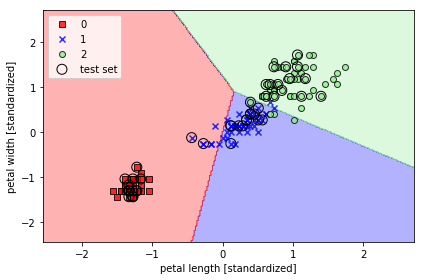

In [8]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/03_01.png', dpi=300)
plt.show()

### ロジスティック回帰を使ってクラスの確率を予測

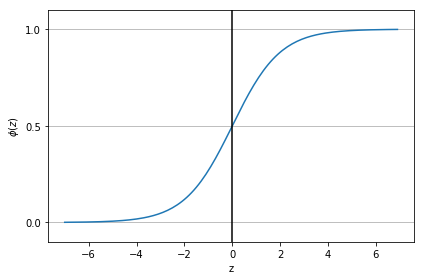

In [9]:
import matplotlib.pyplot as plt
import numpy as np


def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)

plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
#plt.savefig('images/03_02.png', dpi=300)
plt.show()

$\phi(z)$の様々な値に対する１つのサンプルの分類コストを具体的に示すグラフをプロットする。

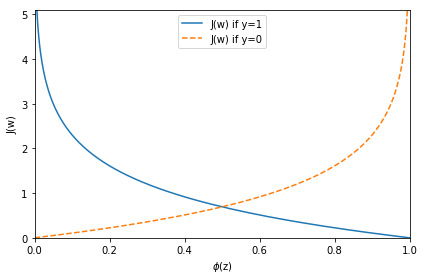

In [10]:
def cost_1(z):
    return - np.log(sigmoid(z))


def cost_0(z):
    return - np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)

c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')

c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')

plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
#plt.savefig('images/03_04.png', dpi=300)
plt.show()

### ロジスティック回帰のアルゴリズムの実装

In [11]:
class LogisticRegressionGD(object):
    """勾配降下法に基づくロジスティック回帰分類器
    パラメータ
    -------------
    eta : float
        学習率（0.0より大きく1.0以下の値）
    n_iter : int
        トレーニングデータのトレーニング個数
    random_state : int
        重みを初期化するための乱数シード
        
    属性
    -------------
    w_ : 一次元配列
        適合後の重み
    cost_ : リスト
        各エポックでの誤差平方和コスト関数
    """
    
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        # 学習率の初期化
        self.eta = eta
        # トレーニング回数の初期化
        self.n_iter = n_iter
        # 乱数シードを固定するrandom_state
        self.random_state = random_state
        
    def fit(self, X, y):
        """トレーニングデータに適合させる
        
        パラメータ
        -------------
        X : {配列のような構造}, shape = [n_samples, n_features]
            トレーニングデータ
            n_samplesはサンプルの個数, n_featuresは特徴量の個数
        y : 配列のようなデータ構造, shape = [n_samples]
            目的変数
        
        戻り値
        -------------
        self : object
        """
        
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1+X.shape[1])
        self.cost_ = list()
        
        # トレーニング回数分トレーニングデータを反復処理
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            # 誤差平方和のコストでなく、ロジスティック回帰のコストを計算
            cost = -y.dot(np.log(output)) - ((1-y).dot(np.log(1-output)))
            # エポックごとのコストを格納
            self.cost_.append(cost)
            
        return self
    
    def net_input(self, X):
        """総入力を計算"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, z):
        """ロジスティックシグモイド活性化関数を計算"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def predict(self, X):
        """1ステップ後のクラスラベルを返す"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)

In [12]:
X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)] # X_trainの教師が　0 or 1　のものだけ抜き出し
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)] # 同様

In [13]:
# ロジスティック回帰のインスタンス
lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1)

In [14]:
# モデルをトレーニングデータに適合
lrgd.fit(X_train_01_subset, y_train_01_subset)

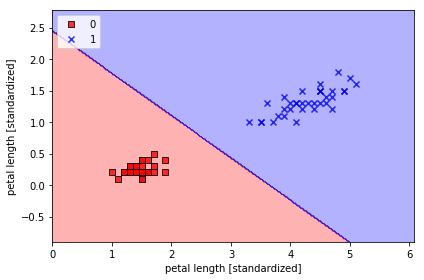

In [15]:
plot_decision_regions(X = X_train_01_subset,
                     y = y_train_01_subset,
                     classifier=lrgd)
# 軸ラベルを設定
plt.xlabel('petal length [standardized]')
plt.ylabel('petal length [standardized]')
# 凡例を設定
plt.legend(loc='upper left')
# グラフを表示
plt.tight_layout()
plt.show()

### scikit-learnを使ったロジスティック回帰モデルのトレーニング

In [16]:
from sklearn.linear_model import LogisticRegression

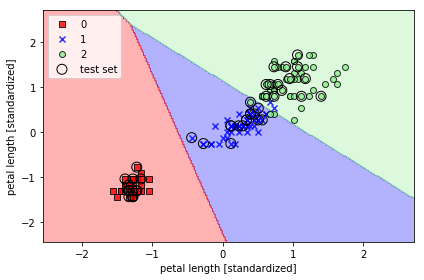

In [17]:
# ロジスティック回帰のインスタンスを生成
lr = LogisticRegression(C=100.0, random_state=1)
# トレーニングデータをモデルに適合
lr.fit(X_train_std, y_train)
# 決定境界をプロット
plot_decision_regions(X_combined_std,
                     y_combined,
                     classifier=lr, test_idx=range(105, 150))
# 軸ラベルを設定
plt.xlabel('petal length [standardized]')
plt.ylabel('petal length [standardized]')
# 凡例を設定
plt.legend(loc='upper left')
# グラフを表示
plt.tight_layout()
plt.show()

トレーニングサンプルが特定のクラスに属する確率は以下のように計算できる。<br>

In [18]:
lr.predict_proba(X_test_std[:3, :])

array([[3.20136878e-08, 1.46953648e-01, 8.53046320e-01],
       [8.34428069e-01, 1.65571931e-01, 4.57896429e-12],
       [8.49182775e-01, 1.50817225e-01, 4.65678779e-13]])

In [19]:
lr.predict(X_test_std[:3, :])

array([2, 0, 0])

### 正則化による過学習への対処

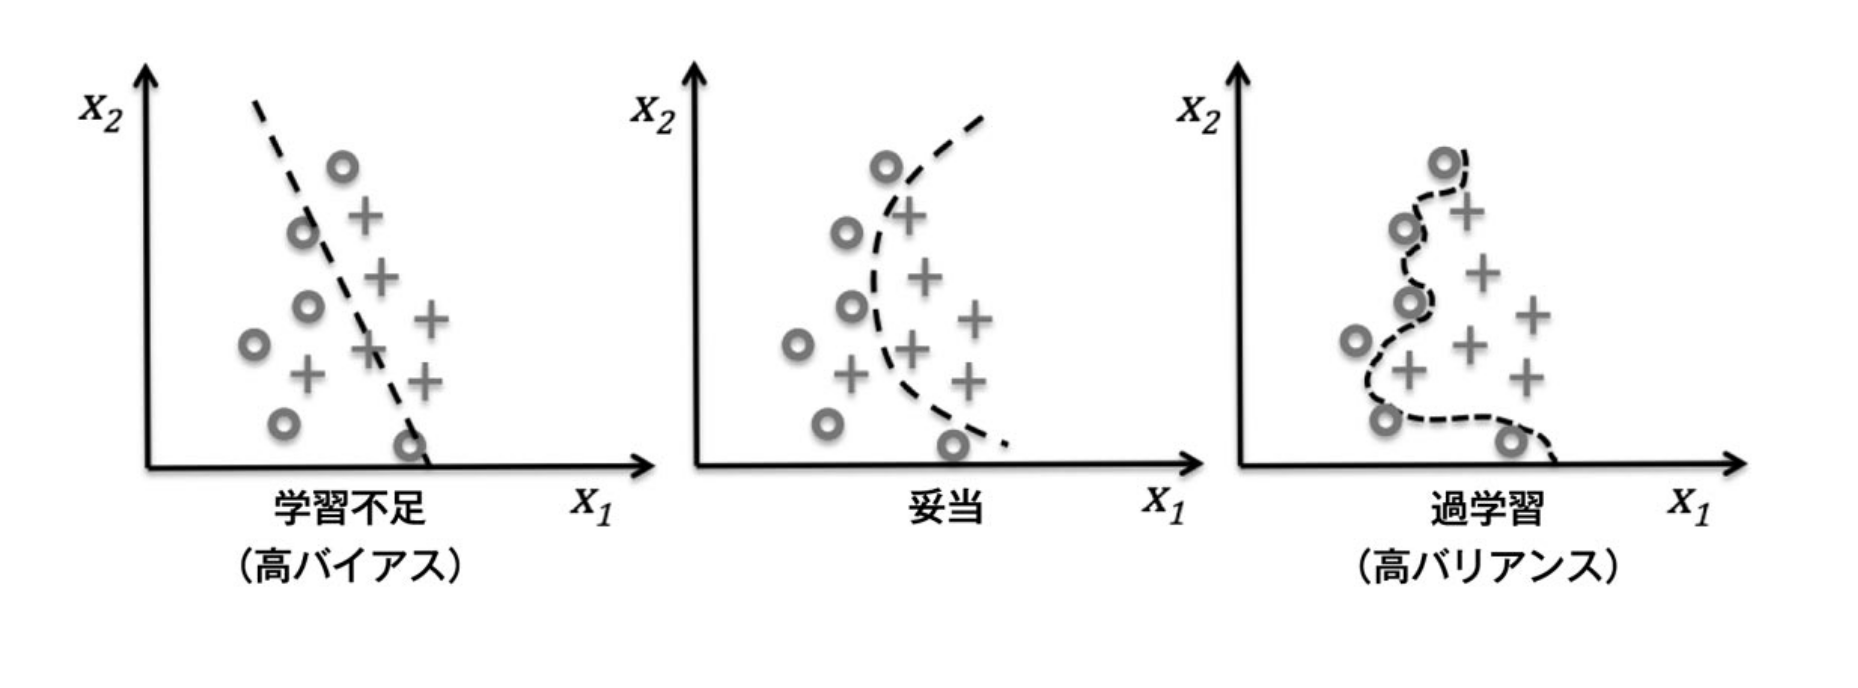

In [20]:
# 画像の表示
from IPython.display import Image
Image(filename='IMG/00.png', width=600)

バリアンスとは、モデルのトレーニングを繰り返した場合に、モデルの一貫性を計測するもの。<br>
バリアンスが高いとは、モデルがトレーニングデータのランダム性に対して敏感であると表現できる。<br>
バイアスとは、モデルを異なるトレーニングデータセットで何度か構築した場合に、予測が正しい値からどの程度外れているかを計測。<br>

バイアスとバリアンスのトレードオフを探る１つの手法として、正則化に基づいてモデルの複雑さの調整があげられる。<br>
正則化は共線性を処理するのに非常に便利な手法であり、データから「ノイズ」を取り除き、最終的に過学習を防ぐ。<br>

正則化の背景にある考え方は、極端なパラメータの重みにペナルティを科すということ。<br>
ロジスティック回帰の逆正則化パラメータCの値を減らすことは、正則化の強さを高めることを意味している。<br>
正則化の強さを可視化するには、２つの重み係数と逆正則化パラメータの関係をプロットする。<br>

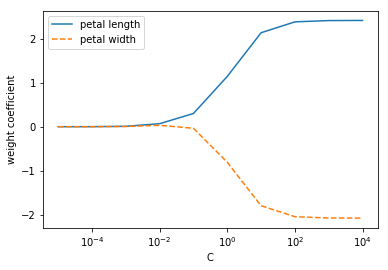

In [21]:
# 空のリストを生成
weights  = list()
params = list()
# 10個の逆正則化パラメータに対応するロジスティック回帰モデルをそれぞれ処理
for c in np.arange(-5, 5):
    # print(c)
    lr = LogisticRegression(C=10. ** c, random_state=1)
    lr.fit(X_train_std, y_train)
    # 重み係数を格納
    weights.append(lr.coef_[1])
    # print(weights)
    # 逆正則化パラメータを格納
    params.append(10. ** c)

# 重み係数をNumpy配列に変換
weights = np.array(weights)

# 横軸に逆正則化パラメータ、縦軸に重み係数をプロット
plt.plot(params, weights[:, 0], label='petal length')
plt.plot(params, weights[:, 1], linestyle='--', label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()

結果から分かるように、パラメータCが減少し、正則化の強さが増すと、重み係数が0に近づいていく。

### サポートベクトルマシンによる最大マージン分類

以下のURLが詳しい。

http://www.sist.ac.jp/~kanakubo/research/neuro/supportvectormachine.html

SVMモデルのトレーニングを行って、Irisデータセットの品種の分類

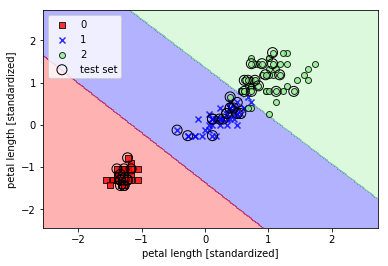

In [22]:
from sklearn.svm import SVC
# 線形SVMのインスタンスを生成
svm = SVC(kernel='linear', C=1.0, random_state=1)
# 線形SVMのモデルにトレーニングデータを適合させる
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.show()

### カーネルSVMを使った非線形問題の求解

#### 線形分離不可能なデータに対するカーネル手法

このデータセットでは、100個のサンプルにクラスラベル1を割り当て、その他の100個のサンプルに-1を割り当てる。<br>

In [23]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
# グラフをjupyter notebook内に表示
%matplotlib inline

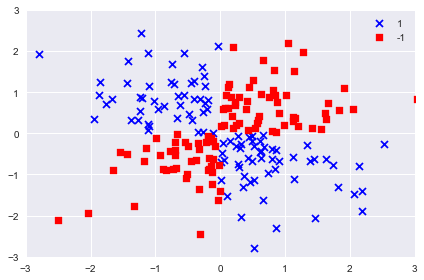

In [24]:
import numpy as np
# 乱数シードを指定
np.random.seed(1)
# 標準正規分布に従う乱数で200行2列の行列を作成
X_xor = np.random.randn(200, 2)
# 2つの引数に対して排他的論理和を実行
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
# 排他的論理和の値が真の場合は１、偽の場合は-1を当てはめる
y_xor = np.where(y_xor, 1, -1)
# ラベル1を青のxでプロット
plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='b', marker='x',
            label='1')
plt.scatter(X_xor[y_xor == -1, 0],
            X_xor[y_xor == -1, 1],
            c='r',
            marker='s',
            label='-1')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
#plt.savefig('images/03_12.png', dpi=300)
plt.show()

### カーネルトリックを使って分離超平面を高次元空間で特定する

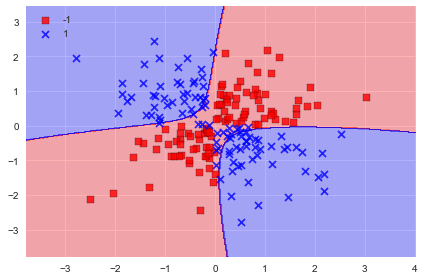

In [25]:
# RBFカーネルによるSVMのインスタンスを生成
svm = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

$\gamma$パラメータの値を大きくすると、トレーニングサンプルの影響力が大きくなり、<br>
到達範囲が広くなる。<br>
それにより、決定境界がより狭くなり、突き出したようになる。<br>
$\gamma$パラメータに対する直観を養うために、RBFカーネルSVMをIrisデータに適用する。<br>

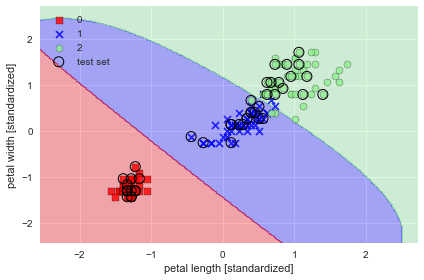

In [26]:
# RBFカーネルによるSVMインスタンスを生成
svm = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_15.png', dpi=300)
plt.show()

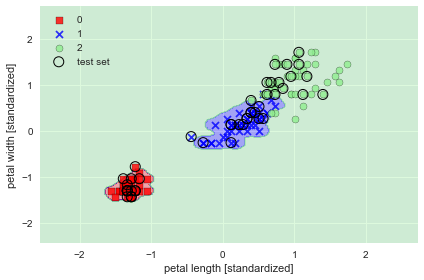

In [27]:
# RBFカーネルによるSVMインスタンスを生成
svm = SVC(kernel='rbf', random_state=1, gamma=100.0, C=1.0)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_15.png', dpi=300)
plt.show()

結果として得られてグラフから、$\gamma$パラメータに比較的大きな値を使用すると、<br>
クラス0とクラス１の周りの境界がかなり複雑になることがわかる。<br>
過学習を起こしている可能性が高いことがわかる。<br>

### 決定木学習

一連の質問に基づいて決断を下すという手法により、データを分類するモデル。<br>

ジニ不純度、エントロピー、分類誤差について視覚的に比較する。<br>

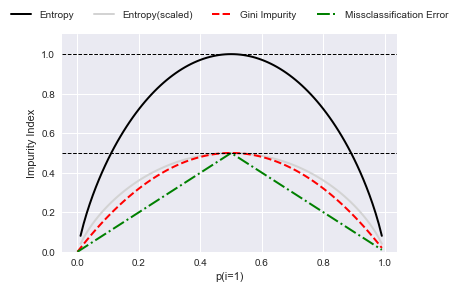

In [31]:
import matplotlib.pyplot as plt
import numpy as np
# ジニ不純度の関数を定義
def gini(p):
    return (p)*(1-(p)) + (1-p)*(1-(1-p))

# エントロピーの関数を定義
def entropy(p):
    return - p*np.log2(p) - (1-p)*np.log2((1-p))

# 分類誤差の関数を定義
def error(p):
    return 1- np.max([p, 1-p])

# 確率を表す配列を生成(0から0.99まで0.01刻み)
x = np.arange(0.0, 1.0, 0.01)

# 配列の値を元にエントロピー, 分類誤差を計算
ent = [entropy(p) if p!=0 else None for p in x]
sc_ent = [e*0.5 if e else None for e in ent]
err = [error(i) for i in x]

# 図の作成を開始
fig = plt.figure()
ax = plt.subplot(111)
# エントロピー（２種）、ジニ不純度、分類誤差のそれぞれをループ処理
for i, lab, ls, c in zip([ent, sc_ent, gini(x), err],
                        ['Entropy', 'Entropy(scaled)', 'Gini Impurity', 'Missclassification Error'],
                        ['-', '-', '--', '-.'],
                        ['black', 'lightgray', 'red', 'green', 'cyan']):
        line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=5, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
#plt.savefig('images/03_19.png', dpi=300, bbox_inches='tight')
plt.show()

### 決定木の構築

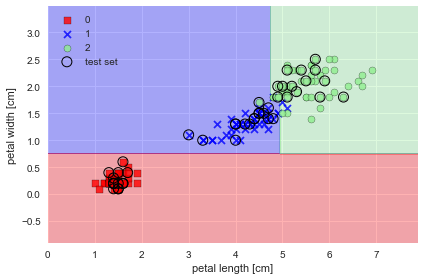

In [33]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=4, 
                              random_state=1)
tree.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_20.png', dpi=300)
plt.show()

In [35]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           class_names=['Setosa', 
                                        'Versicolor',
                                        'Virginica'],
                           feature_names=['petal length', 
                                          'petal width'],
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('tree.png')

True

### ランダムフォレスト